# A Bayesian approach to model fitting
### August George - 11/2020
**pyMC3 Reference** https://docs.pymc.io/notebooks/GLM-linear.html

### Motivation:

Intuitively, the Bayesian approach to statistics provides a tool to update the belief in an event based on new data.

Here we examine how to apply Bayesian statistics to fit a linear model to noisey data.

### Introduction:

Consider an experiment that generates linear data that and contains some amount of error ($\epsilon$): $ y_{i} = (ax_{i} + b) + \epsilon_{i}$. For this exercise we will assume that noise is generated from a Guassian distribution with a mean of zero and a fixed (but unknown) standard deviation parameter, $\sigma$. 

We would like to estimate the parameters for this model, $(a,b,\sigma)$. One common way to estimate these parameters is to use linear regression. In our case, we would like to find the *distribution* of parameter values given the data - which leads us to Bayes' theorem and Bayesian inference. 



### Bayes' Theorem: 
$p(\theta | \mathrm{data}) = \dfrac{\mathcal{L} (\mathrm{data} | \theta ) p(\theta)}{p(\mathrm{data})}$

where $p(\theta | \mathrm{data})$ is referred to as the *posterior*, $\mathcal{L} (\mathrm{data} | \theta )$ as the *likelihood*, $p(\theta)$ as the *prior*, and $p(\mathrm{data})$ as the *evidence*. $\theta$ represents our parameters $(a,b,\sigma)$.

We would like to calculate the *posterior* which is the distribution of parameter values given the data. The evidence term is calculated from an integral, $p(\mathrm{data}) = {\displaystyle \int_{\theta}^{} p(\mathrm{data} | \theta ) p(\theta)  \ \mathrm{d}\theta }$ - which is often infeasible to solve analytically or numerically. As a result the posterior often cannot be calculated directly. 

#### Notes on MCMC:
An alternative form of Bayes' Theorem excludes the evidence term: $p(\theta | \mathrm{data}) \propto \mathcal{L} (\mathrm{data} | \theta ) p(\theta)$

Often logs are used to calculate the probabilities to reduce numerical issues w/ very small probabilities. 

### Markov chain Monte Carlo (MCMC)

One approach is to generate a Markov chain with a stationary distribution that matches the desired (i.e. $p(\theta | \mathrm{data})$) distribution. With enough samples, this Markov chain will represent the desired distribution. For this example we will use the random walk Metropolis-Hastings algorithm.

### Random walk Metropolis-Hastings Monte Carlo

1. Intialization: Choose initial $\theta_{t=0}$ 
2. For $t = 1,...,m$:  
    1. Select canditate $\theta^{*}$ from a symmetric distribution: $q(\theta^{*}|\theta_{t-1})$
    2. Calculate acceptance ratio: $\alpha = \dfrac{\mathcal{L}(\mathrm{data} | \theta^{*} ) p(\theta^{*})}{\mathcal{L}(\mathrm{data} | \theta_{t-1} ) p(\theta_{t-1})}$
    3. For $\alpha \geq 1$:
        1. accept candidate: $\theta_{t} \leftarrow \theta^*$
       
       For  $0 < \alpha < 1$:
        1. accept candidate: $\theta_{t} \leftarrow \theta^*$ with probability $\alpha$
        2. reject candidate: $\theta_{t} \leftarrow \theta_{t-1}$ with probability $1-\alpha$
  
  
#### Notes on MCMC:

A common choice of the candidate selection distribution, $q(\theta)$, is a Guassian with $\mu = \theta_{t-1}$.

A 'burn in' can be used to elemenate the first $n$ candidates which may be far from the stationary distribution. 



### Useful definitions:

##### Gaussian distribution: $p(x) = \dfrac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \left(\frac{x-\mu}{\sigma}\right)^2 }$

### Example:

Generate synthetic experimental data from a linear function with Gaussian noise, and develop a Bayesian MCMC sampler of the posterior.  Use a prior of your choice.  From that  generate the 95% CR. 

**Bayes' Theorem:** $p(\theta | \mathrm{data}) = \dfrac{\mathcal{L} (\mathrm{data} | \theta ) p(\theta)}{p(\mathrm{data})}$

**Model:** $y_{i} = (ax_{i} + b) + \epsilon_{i} ,  $ where $\epsilon$ is drawn from a Guassian distribution, $N(\mu_{\epsilon}=0, \sigma_{\epsilon}=\sigma_{\mathrm{True}})$.

**Unkown model parameters:** $\theta = (a,b,\sigma_{\epsilon})$

**Likelihood:** $\mathcal{L}(\mathrm{data} | \theta ) = \mathcal{L}(y | (a,b,\sigma_{\epsilon}) ) = \sum_{i} log(N(\mu=ax_{i} + b,\sigma=\sigma_{\epsilon}))$

**Priors:** Choose distibutions for the priors (e.g. normal or uniform), $p(\theta) = p(a)*p(b)*p(\sigma_{\epsilon})$

**Posterior:** $p(\theta | \mathrm{data}) \propto \mathcal{L} (\mathrm{data} | \theta ) p(\theta)$

**Candidate selection distribution**: For Metropolis - choose a Normal distibution $\sim N(\mu=\theta_{t-1}, \sigma=\sigma_{candidate})$ 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [slope, Intercept, sigma]
Sampling 3 chains, 0 divergences: 100%|██████████| 15000/15000 [00:06<00:00, 2396.81draws/s]


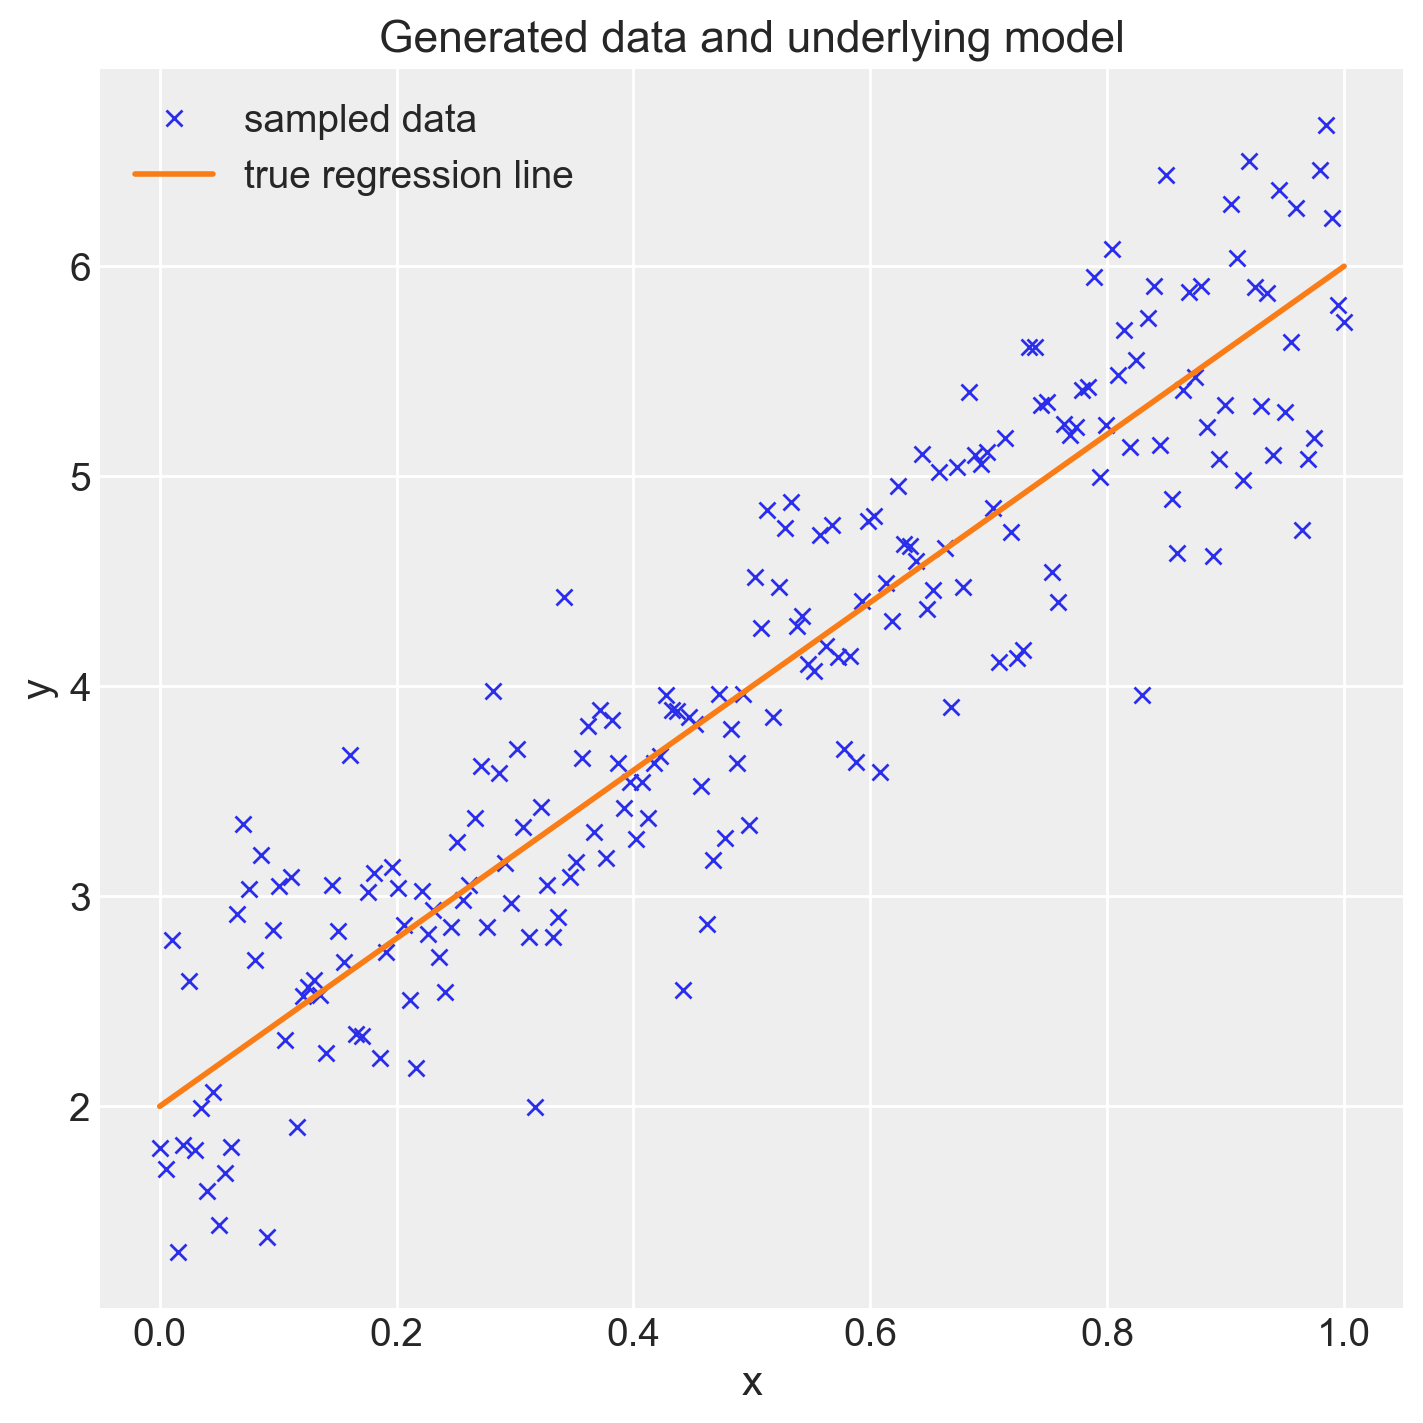

<Figure size 700x700 with 0 Axes>

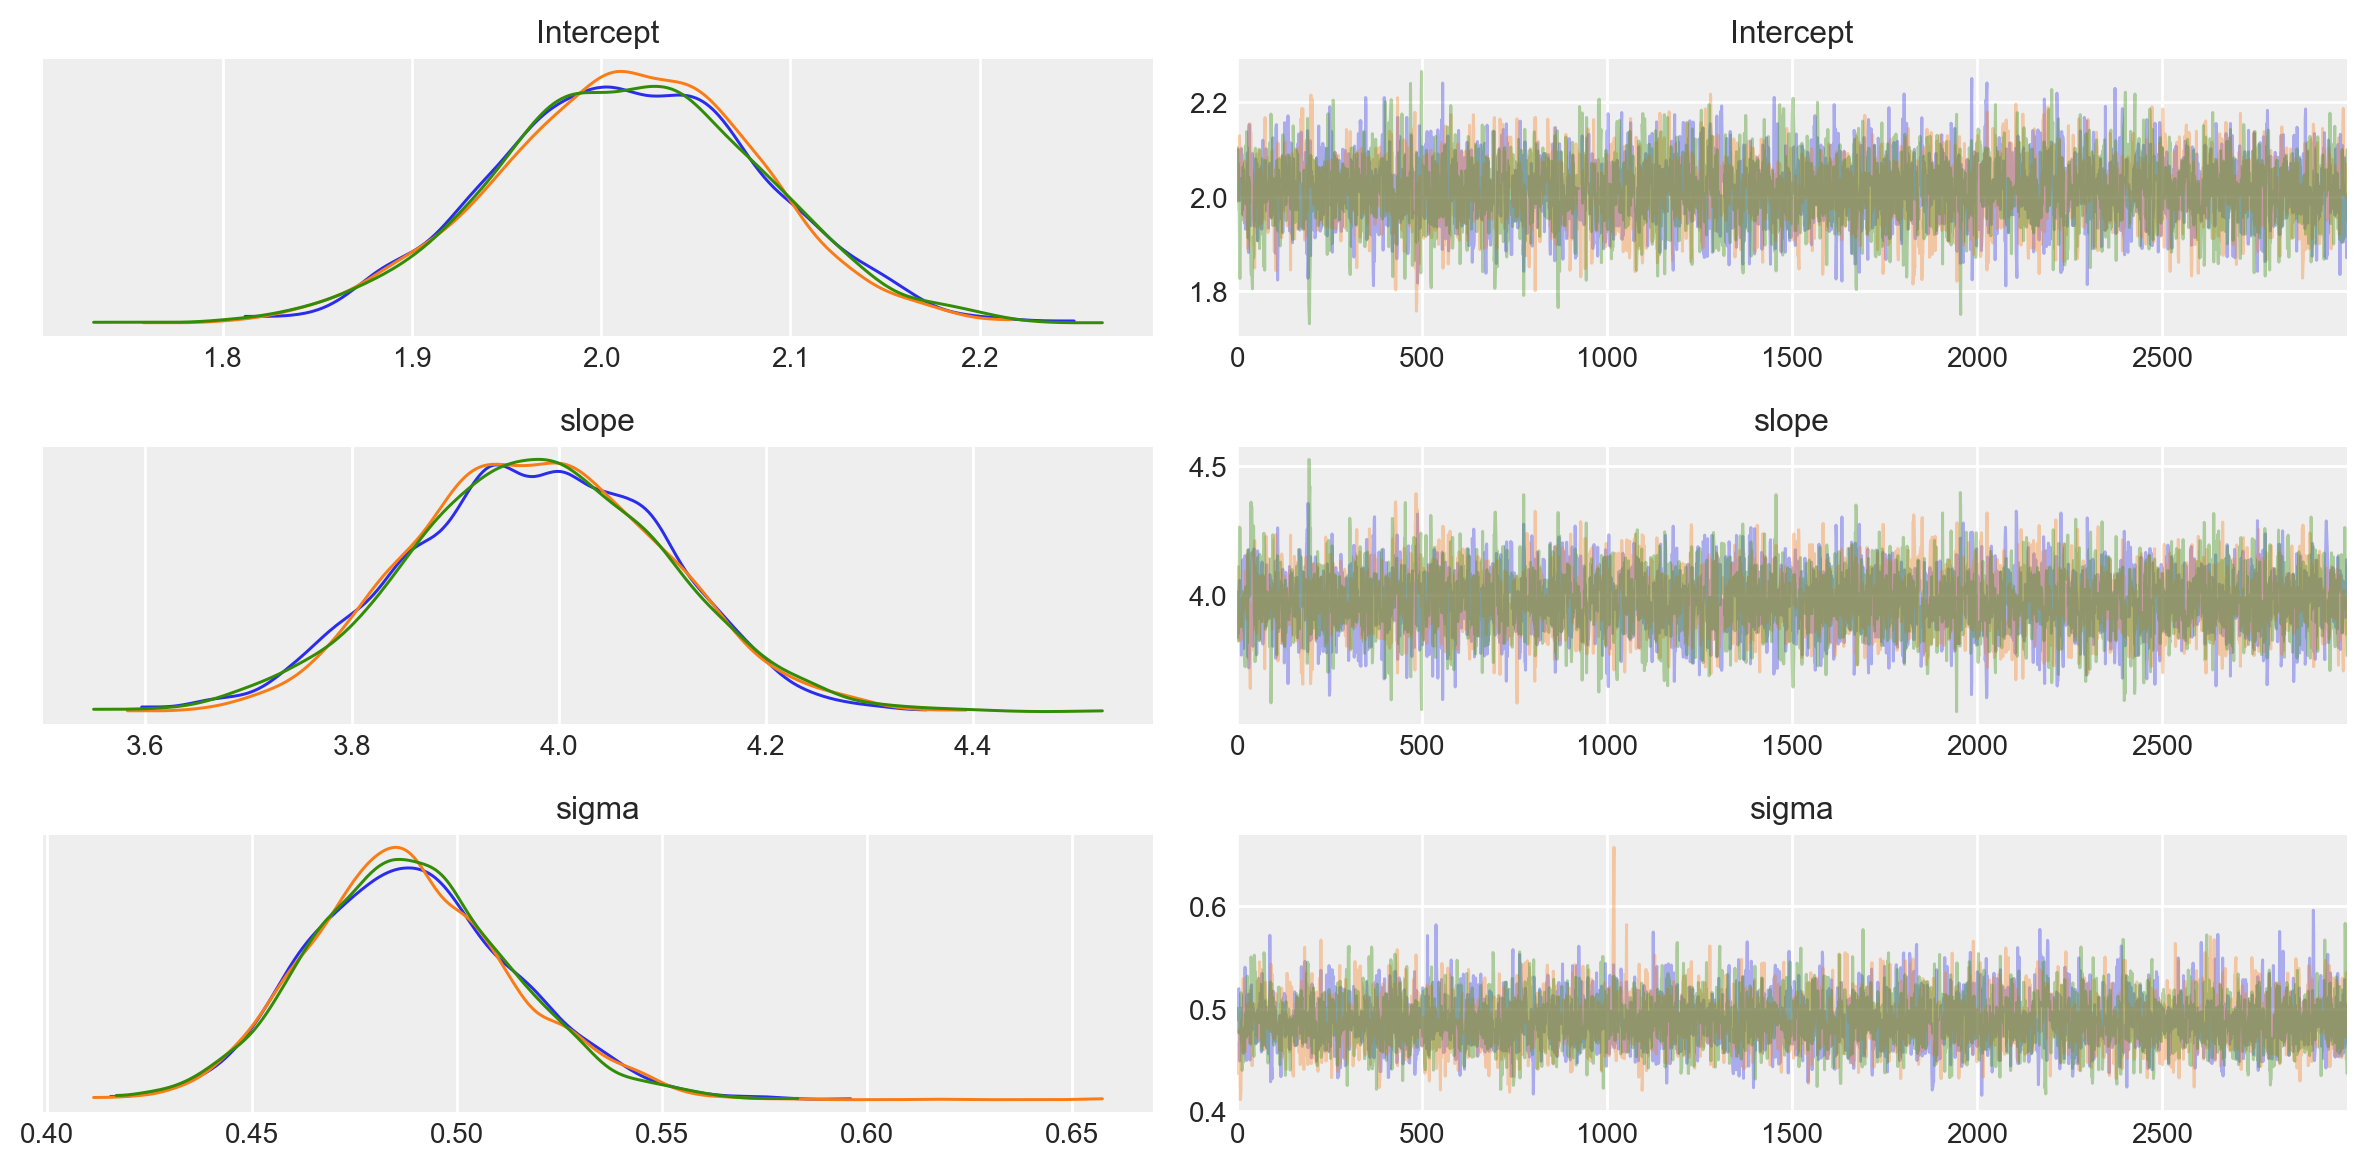

<Figure size 700x700 with 0 Axes>

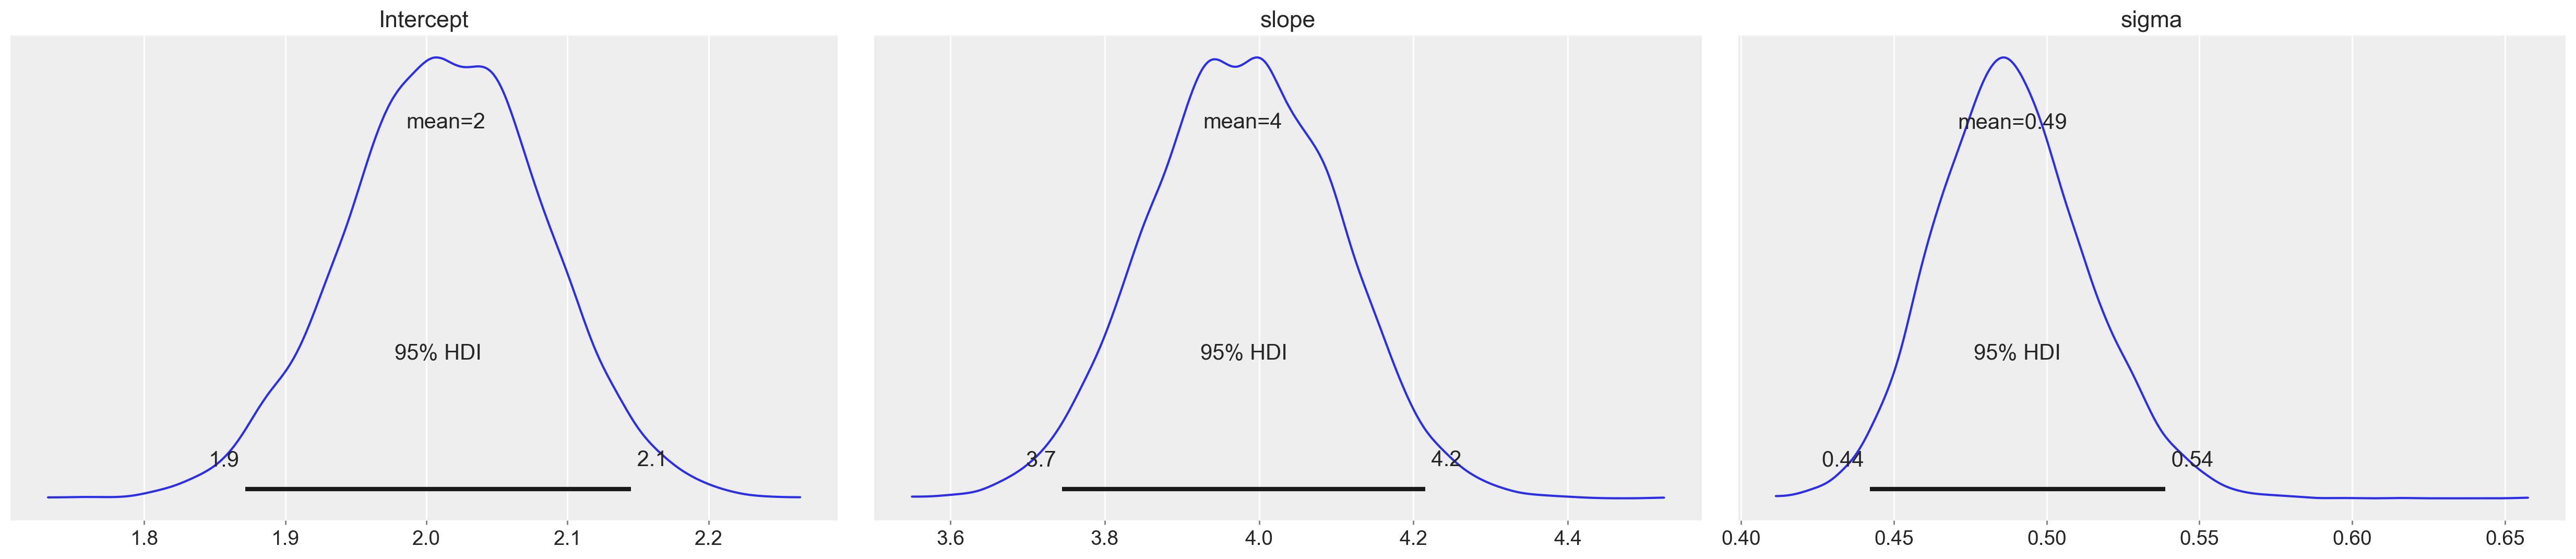

In [158]:
### Import libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pymc3 import  *

### Set display options
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

### True parameters for linear model
true_intercept = 2
true_slope = 4
true_sigma = 0.5

### Generate synthetic data 
size = 200
x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x  # y = a + b*x
y = true_regression_line + np.random.normal(scale=true_sigma, size=size)  # add noise

### Plot linear model w/ data
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data');
ax.plot(x, true_regression_line, label='true regression line', lw=2.);
plt.legend(loc=0);

### Construct model using pyMC3
with Model() as model: 
    
    ### Define priors
    
    #sigma = HalfCauchy('sigma', beta=10, testval=1.)
    #sigma = Uniform('sigma', 0,1)
    sigma = Lognormal('sigma', 0, sigma=20)
    Intercept = Normal('Intercept', 0, sigma=20)
    x_coeff = Normal('slope', 0, sigma=20)

    ### Define likelihood
    likelihood = Normal('y', mu=Intercept + x_coeff * x,
                        sigma=sigma, observed=y)

    ### Inference
    trace = sample(3000, cores=3, tune=2000) # draw 3000 posterior samples using NUTS (MCMC w/ gradient) sampling

### Plot traces
plt.figure(figsize=(7, 7))
az.plot_trace(trace);
plt.tight_layout();

### Plot posterior w/ credible region
plt.figure(figsize=(7, 7))
az.plot_posterior(trace, hdi_prob=0.95);
plt.tight_layout();